In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Prepare basic parameters

In [5]:
# define the years to be classified
year_name  = list([f'{span[0]}_{span[1]}' for span in zip(range(1990,2020,3),range(1992,2020,3)) ])

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
year_name

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

##### Prepare input_image for classification

In [7]:
# import Landsat img
Landsat_img = [ee.Image(f"users/wang8052664/Cloud_Free_Img/Landsat_cloud_free_{year}")\
                 .clip(North_China_Plain)  for year in year_name]

# import Fourier img   
Fourier_img = [ee.Image(f"users/Jinzhu_Deakin/North_China_Plain/Fourier_img_harmonic_3/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[:5]] + \
              [ee.Image(f"users/wang8052664/North_China_Plain/Fourier_imgs/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[5:]] 

# Import the Index-mean Img
NDVI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_NDVI").rename('Mean_NDVI')  
            for year in year_name ]
NDBI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_NDBI").rename('Mean_NDBI')  
            for year in year_name ]
EVI_img  = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_EVI").rename('Mean_EVI')  
            for year in year_name ]

# stack Landsat_Fourier_Nomalized together
Stack_img = [ee.Image(img) for img in zip(Landsat_img,Fourier_img,NDVI_img,NDBI_img,EVI_img)]

##### Prepare input sample points

In [8]:
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# Option_1: Use the Invarient points
Invarient_non_built_sample = [ee.FeatureCollection(f'{path}/Invarient_non_built_{year}')\
                                .filterMetadata('Built','equals',0) for year in year_name]
Invarient_built_sample     = [ee.FeatureCollection(f'{path}/Invarient_built_{year}')
                                for year in year_name]
Invarient_sample_merge     = [i[0].merge(i[1]) for i in zip(Invarient_non_built_sample,
                                                            Invarient_built_sample)]

##### Stack input_img and input_sample together

In [9]:
# first put all inputs together
stack_name   = ['Invarient'] * len(Invarient_sample_merge)

stack_year   = year_name 
stack_img    = Stack_img 
stack_sample = Invarient_sample_merge 

# stack all ingredients together
Stack_img_sample = [(stack_name[i],stack_year[i],stack_img[i],stack_sample[i]) for i in range(len(stack_name))]

In [ ]:
Stack_img_sample

In [11]:
# A two-layer loop to generate 10-randome-split layers for each year-period

Classificatioin_result = []

# The first-layer loop to go througth each year-periods
for input_variable in Stack_img_sample:
    
    classificaiton_tpye = input_variable[0]
    year = input_variable[1]
    sample_pt = input_variable[3]
    input_img = input_variable[2]
    input_band = input_img.bandNames().getInfo()

    # The second-layer to go through each-randomnes
    for seed in range(10):
        
        # Instatiate the class with a name.
        classification = Classification(year_name      = year,
                                        Verified_point = sample_pt,
                                        Input_img      = input_img,
                                        Input_band     = input_band,
                                        Tree_num       = 100,
                                        seed           = seed,
                                        Zone_sample    = None,
                                        classProperty  = 'Built')


        # perform the classification on Input_img and Samples
        classification.Stp_1_Classification_on_img()
        classification.Stp_2_Classification_on_Samples()

        # Get the classified img
        classified_img = classification.classification_img

        # Get the classified samples
        train_sample_classified        = classification.Train_sample_classification
        test_sample_classified         = classification.Test_sample_classification

        # add classfication into the list
        Classificatioin_result.append((classificaiton_tpye,year,seed,classified_img,test_sample_classified))

In [12]:
# convert classificaiton instances into a dataframe
Classification_instances_df =  pd.DataFrame(Classificatioin_result,
                                            columns=['classificaiton_tpye','year','seed','classified_img','test_sample_classified'])
Classification_instances_df

,classificaiton_tpye,year,seed,classified_img,test_sample_classified
0,Invarient,1990_1992,0,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
1,Invarient,1990_1992,1,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
2,Invarient,1990_1992,2,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
3,Invarient,1990_1992,3,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
4,Invarient,1990_1992,4,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
...,...,...,...,...,...
95,Invarient,2017_2019,5,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
96,Invarient,2017_2019,6,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
97,Invarient,2017_2019,7,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
98,Invarient,2017_2019,8,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."


In [36]:
# calculate the accuracy of each radomness

acc = []

# calculate the accuracy of differnet randomness
for i in Classificatioin_result:
    
    accuracy = Accuracy_assesment(i[4]).Stp_1_Calculate_Accuracy()
    acc.append(accuracy)
    
    key = 'Recall_built'
    print(f'{i[1]}_{i[2]}-->Recall_built:{accuracy[key]}')

1990_1992_0-->Recall_built:93.63
1990_1992_1-->Recall_built:92.93
1990_1992_2-->Recall_built:93.04
1990_1992_3-->Recall_built:93.54
1990_1992_4-->Recall_built:92.93
1990_1992_5-->Recall_built:92.75
1990_1992_6-->Recall_built:92.74
1990_1992_7-->Recall_built:93.47
1990_1992_8-->Recall_built:92.52
1990_1992_9-->Recall_built:93.12
1993_1995_0-->Recall_built:92.79
1993_1995_1-->Recall_built:92.06
1993_1995_2-->Recall_built:93.13
1993_1995_3-->Recall_built:92.91
1993_1995_4-->Recall_built:92.54
1993_1995_5-->Recall_built:92.52
1993_1995_6-->Recall_built:92.26
1993_1995_7-->Recall_built:93.16
1993_1995_8-->Recall_built:92.29
1993_1995_9-->Recall_built:93.1
1996_1998_0-->Recall_built:92.44
1996_1998_1-->Recall_built:91.81
1996_1998_2-->Recall_built:92.7
1996_1998_3-->Recall_built:93.0
1996_1998_4-->Recall_built:92.44
1996_1998_5-->Recall_built:92.02
1996_1998_6-->Recall_built:91.7
1996_1998_7-->Recall_built:92.76
1996_1998_8-->Recall_built:92.13
1996_1998_9-->Recall_built:92.4
1999_2001_0-->R

In [45]:
# store the acc_df to local drive

# acc_df = pd.concat([Classification_instances_df[['year','seed']],pd.DataFrame(acc)],axis=1)
# acc_df.to_csv('./Step_2_Result/Randome_Accuracy.csv',index=False)

# access the acc_df
acc_df = pd.read_csv('./Step_2_Result/Randome_Accuracy.csv',)
acc_df

,year,seed,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,1990_1992,0,92.48,93.48,91.53,91.33,93.63
1,1990_1992,1,92.94,92.74,93.13,92.95,92.93
2,1990_1992,2,92.33,93.11,91.56,91.64,93.04
3,1990_1992,3,93.23,93.46,93.01,92.93,93.54
4,1990_1992,4,92.20,92.55,91.88,91.45,92.93
...,...,...,...,...,...,...,...
95,2017_2019,5,90.93,89.45,92.46,92.46,89.45
96,2017_2019,6,90.28,88.65,92.08,92.52,88.02
97,2017_2019,7,91.10,89.49,92.87,93.25,88.92
98,2017_2019,8,91.33,90.32,92.43,92.89,89.71


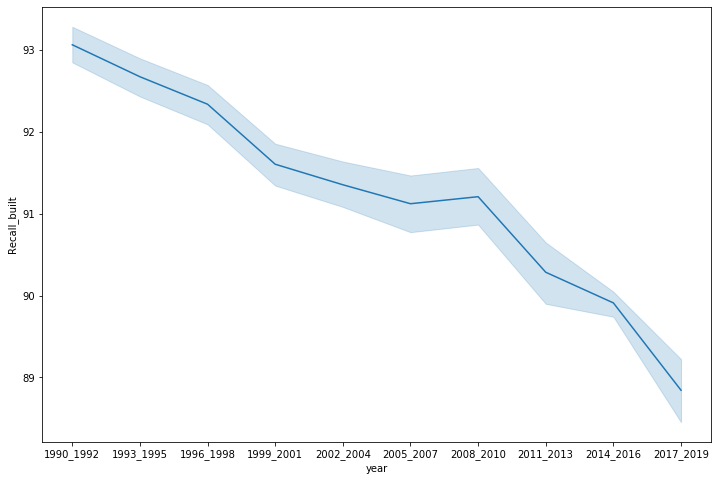

In [50]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='Recall_built',data=acc_df)

##### Export the result

In [13]:
for item in Classificatioin_result:
     
    Classification_type = item[0]
    year = item[1]
    seed = item[2]
    img  = item[3]
    
    
    export_name = f'{Classification_type}_{year}_random_{seed}'
    
#     task = ee.batch.Export.image.toCloudStorage(image          = img,
#                                                 description    = export_name,
#                                                 bucket         = 'north_china_plain/Classification_Invarient',
#                                                 fileNamePrefix = export_name,
#                                                 region         = North_China_Plain.geometry().bounds(),
#                                                 scale          = 30,
#                                                 maxPixels      = int(1e13),
#                                                 skipEmptyTiles = True)
#     task.start()
    
    print(f'Exporting {export_name} successful!')

Exporting Invarient_1990_1992_random_0 successful!
Exporting Invarient_1990_1992_random_1 successful!
Exporting Invarient_1990_1992_random_2 successful!
Exporting Invarient_1990_1992_random_3 successful!
Exporting Invarient_1990_1992_random_4 successful!
Exporting Invarient_1990_1992_random_5 successful!
Exporting Invarient_1990_1992_random_6 successful!
Exporting Invarient_1990_1992_random_7 successful!
Exporting Invarient_1990_1992_random_8 successful!
Exporting Invarient_1990_1992_random_9 successful!
Exporting Invarient_1993_1995_random_0 successful!
Exporting Invarient_1993_1995_random_1 successful!
Exporting Invarient_1993_1995_random_2 successful!
Exporting Invarient_1993_1995_random_3 successful!
Exporting Invarient_1993_1995_random_4 successful!
Exporting Invarient_1993_1995_random_5 successful!
Exporting Invarient_1993_1995_random_6 successful!
Exporting Invarient_1993_1995_random_7 successful!
Exporting Invarient_1993_1995_random_8 successful!
Exporting Invarient_1993_1995_r